# Email Classifier Notebook

### Import Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, classification_report
from sklearn import metrics
from catboost import Pool, CatBoostClassifier
import nltk
from nltk.corpus import stopwords
from paramsearch import paramsearch
from itertools import product, chain
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm

### Download NLTK packages

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Functions for data processing and cross validation

In [32]:
from io import StringIO
from html.parser import HTMLParser
import unicodedata


# Class to parse and remove html in email data
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
        self.start_tags = list()
        self.end_tags = list()
        self.attributes = list()
        
    def handle_data(self, d):
        self.text.write(d)
        
    def get_data(self):
        return self.text.getvalue()
    
    def is_text_html(self):
        return True if len(self.start_tags) else False

    def handle_starttag(self, tag, attrs):
        self.start_tags.append(tag)
        self.attributes.append(attrs)
        
# Remove email address if in text
def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', '',x)
    
def check_for_emails(x):
    return 1 if len(re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', x)) else 0

#  remove html tags
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return unicodedata.normalize("NFKD", s.get_data()).encode('ascii', 'ignore').decode('utf-8', 'ignore').replace('&nbs=p;', '').replace('=2C', ',').replace('=2E', '.').replace('=40', '@').replace('=28', '(').replace('=29', ')').replace('=5F', '_').replace('=2F', '/')

def check_for_urls(x):
    return 1 if len(re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)) else 0

def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

def remove_special_chars(x):
    x = re.sub(r'[^\w ]+', " ", x)
    x = ' '.join(x.split())
    return x

def remove_stopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])

# this function does 3-fold crossvalidation with catboostclassifier
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True)
    res = []
    text_features = ['Text']
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.iloc[train_index]
        test_labels = train_label.iloc[test_index]
        train_pool = Pool(
            train,
            labels,
            text_features=text_features,
            feature_names=text_features
        )
        valid_pool = Pool(
            test,
            test_labels,
            text_features=text_features,
            feature_names=text_features
        )
        clf = CatBoostClassifier(**params)


        clf.fit(train_pool, eval_set=valid_pool)

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)

# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()

In [4]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
# Load dataset
df = pd.read_excel('data/phishing_email_.xlsx')

### Preliminary data description

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11929 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    11913 non-null  object
 1   Class   11929 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 186.5+ KB


In [8]:
df.describe()

,Class
count,11929.000000
mean,0.434823
std,0.495754
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
df.Class.value_counts(normalize=True)

0    0.565177
1    0.434823
Name: Class, dtype: float64

Text(0, 0.5, 'classes')

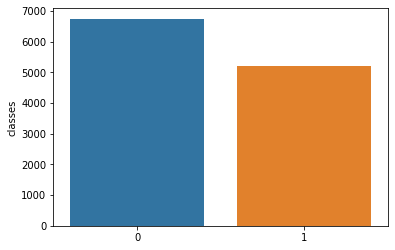

In [10]:
data=df.Class.value_counts()
sns.barplot(x=data.index,y=data)
plt.gca().set_ylabel('classes')

## Data Cleaning and Processing

In [11]:
df['Text']=df['Text'].astype(str)

In [12]:
df['Text'].isnull().sum()

0

In [13]:
df.dropna(inplace=True)

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df = df[df.Text.str.len() > 30]

In [16]:
df['Has_Email'] = df['Text'].apply(lambda x: check_for_emails(x))
df['Has_URL'] = df['Text'].apply(lambda x: check_for_urls(x))

In [17]:
df['Text'] = df['Text'].apply(lambda x: strip_tags(x))

In [18]:
df['Text'] = df['Text'].apply(lambda x: cont_to_exp(x))

In [19]:
df['Text'] = df['Text'].apply(lambda x: remove_special_chars(x))
df['Text'] = df['Text'].apply(lambda x: x.lower())

In [20]:
df['Text_Length'] = df['Text'].apply(lambda x: len(x))

## Exploratory Data Analysis

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9116 entries, 0 to 11928
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         9116 non-null   object
 1   Class        9116 non-null   int64 
 2   Has_Email    9116 non-null   int64 
 3   Has_URL      9116 non-null   int64 
 4   Text_Length  9116 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 427.3+ KB


In [22]:
df.describe()

,Class,Has_Email,Has_URL,Text_Length
count,9116.000000,9116.000000,9116.000000,9116.000000
mean,0.468078,0.159609,0.129882,1359.686485
std,0.499007,0.366264,0.336191,2468.580160
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,103.000000
50%,0.000000,0.000000,0.000000,473.000000
75%,1.000000,0.000000,0.000000,2196.250000
max,1.000000,1.000000,1.000000,49896.000000


In [23]:
df.Class.value_counts(normalize=True)

0    0.531922
1    0.468078
Name: Class, dtype: float64

#### display how the data is shared between the classes

Text(0, 0.5, 'classes')

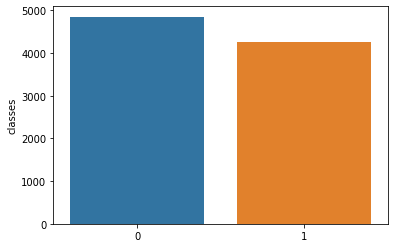

In [24]:
data=df.Class.value_counts()
sns.barplot(x=data.index,y=data)
plt.gca().set_ylabel('classes')

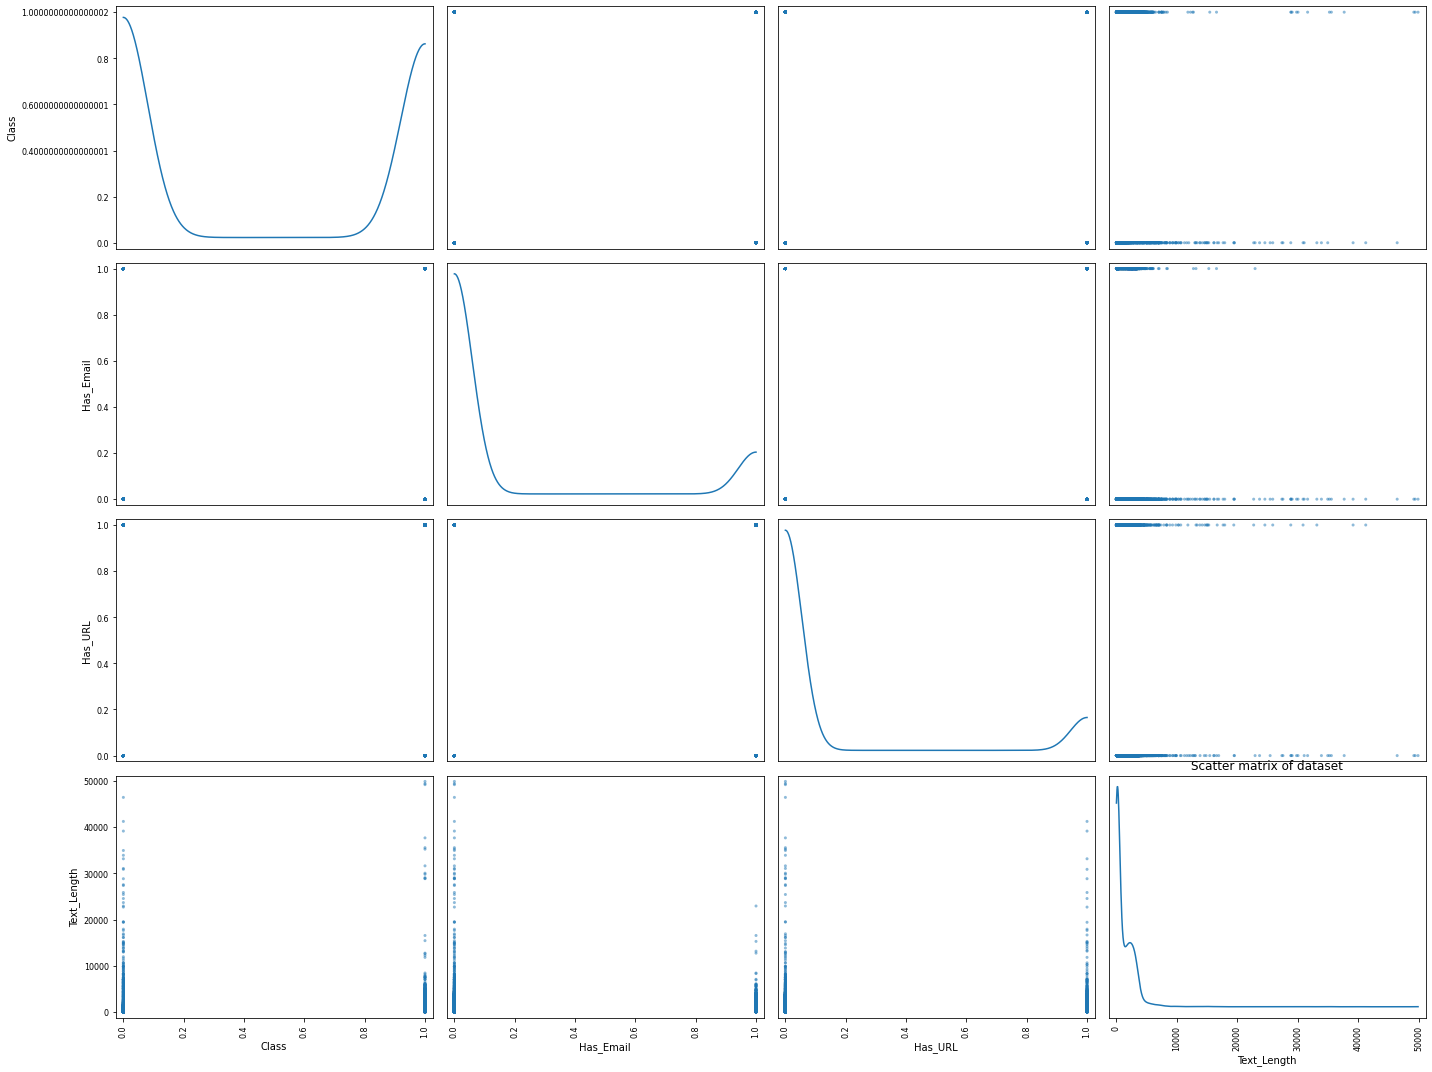

In [25]:
pd.plotting.scatter_matrix(df.loc[:,'Class':'Text_Length'], diagonal='kde', figsize=(20,15))
plt.tight_layout()
plt.title('Scatter matrix of dataset')
plt.show()

In [26]:
correlation_table = df.corr()
correlation_table

,Class,Has_Email,Has_URL,Text_Length
Class,1.000000,0.254480,0.347772,0.303650
Has_Email,0.254480,1.000000,0.155049,0.069567
Has_URL,0.347772,0.155049,1.000000,0.197731
Text_Length,0.303650,0.069567,0.197731,1.000000


Text(0.5, 1.0, 'Heatmap of the dataset correlation')

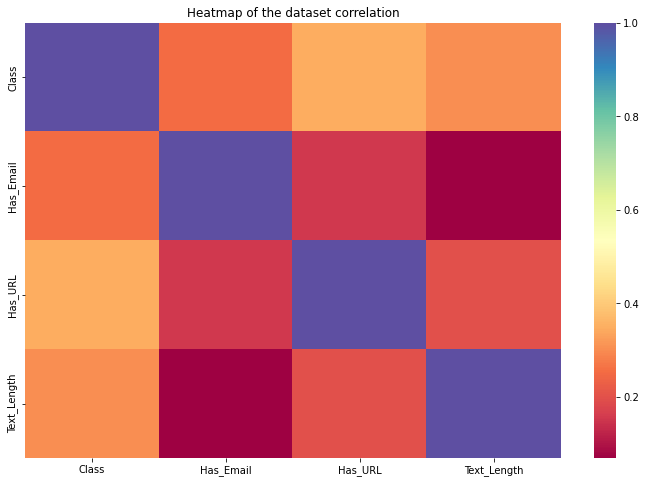

In [27]:
figsize = plt.figure(figsize=(12,8))
sns.heatmap(correlation_table, cmap='Spectral')
plt.title('Heatmap of the dataset correlation')

### Split data into train and testing

In [28]:
X = df.drop(['Class', 'Has_Email','Has_URL', 'Text_Length'], 1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Specifiying the parameters for hyperparameter tuning

In [29]:
cb_params = {'depth':[3,1,2,6,4,5,7,8,9,10],
                'iterations':[250,100,500,1000,1500,2000,2500,3000],
                'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
                'l2_leaf_reg':[3,1,5,10,100],
                'border_count':[32,5,10,20,50,100,200],
                'thread_count':4,
                'eval_metric': 'Accuracy',
                'task_type': 'GPU',
                'early_stopping_rounds': 2000,
                'use_best_model': True,
                'verbose': 500
             }

##### Tune the model using nested cross validation to determing the best hyperparameters

In [33]:
bestparams = catboost_param_tune(cb_params,X_train,y_train)

0:	learn: 0.9677950	test: 0.9689704	best: 0.9689704 (0)	total: 13.3ms	remaining: 3.31s
249:	learn: 0.9750823	test: 0.9741420	best: 0.9741420 (138)	total: 2.43s	remaining: 0us
bestTest = 0.974141984
bestIteration = 138
Shrink model to first 139 iterations.
0:	learn: 0.9722614	test: 0.9844852	best: 0.9844852 (0)	total: 10.1ms	remaining: 2.52s
249:	learn: 0.9771979	test: 0.9802539	best: 0.9844852 (0)	total: 2.39s	remaining: 0us
bestTest = 0.9844851904
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.9732017	test: 0.9760226	best: 0.9760226 (0)	total: 11.9ms	remaining: 2.96s
249:	learn: 0.9844852	test: 0.9863658	best: 0.9877762 (182)	total: 2.44s	remaining: 0us
bestTest = 0.9877762106
bestIteration = 182
Shrink model to first 183 iterations.
0.9821344616831218 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'ver

249:	learn: 0.9868359	test: 0.9901269	best: 0.9915374 (137)	total: 2.55s	remaining: 0us
bestTest = 0.9915373766
bestIteration = 137
Shrink model to first 138 iterations.
0.9918508070835292 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 1, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose': 500} best: 0.9923209529161955 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose': 500}
0:	learn: 0.9720263	test: 0.9830748	best: 0.9830748 (0)	total: 10.7ms	remaining: 2.66s
249:	learn: 0.9863658	test: 0.9934180	best: 0.9948284 (94)	total: 2.36s	remaining: 0us
bestTest = 0.9948283968
bestIteration = 94
Shrink model to first 95 iterations.
0:	learn: 0.9734368	test: 0.9764927	best: 0.9764927 (0)	total: 11.9ms	

0:	learn: 0.9802539	test: 0.9873061	best: 0.9873061 (0)	total: 11.1ms	remaining: 2.77s
249:	learn: 0.9950635	test: 0.9934180	best: 0.9938881 (60)	total: 2.39s	remaining: 0us
bestTest = 0.9938881053
bestIteration = 60
Shrink model to first 61 iterations.
0:	learn: 0.9722614	test: 0.9741420	best: 0.9741420 (0)	total: 12ms	remaining: 2.99s
249:	learn: 0.9960038	test: 0.9905971	best: 0.9905971 (25)	total: 2.47s	remaining: 0us
bestTest = 0.9905970851
bestIteration = 25
Shrink model to first 26 iterations.
0:	learn: 0.9736718	test: 0.9788434	best: 0.9788434 (0)	total: 10.9ms	remaining: 2.72s
249:	learn: 0.9931829	test: 0.9901269	best: 0.9905971 (17)	total: 2.45s	remaining: 0us
bestTest = 0.9905970851
bestIteration = 17
Shrink model to first 18 iterations.
0.9916940918351355 {'depth': 3, 'iterations': 250, 'learning_rate': 0.2, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbos

0:	learn: 0.9724965	test: 0.9774330	best: 0.9774330 (0)	total: 6.62ms	remaining: 655ms
99:	learn: 0.9877762	test: 0.9887165	best: 0.9887165 (30)	total: 552ms	remaining: 0us
bestTest = 0.9887165021
bestIteration = 30
Shrink model to first 31 iterations.
0:	learn: 0.9746121	test: 0.9793136	best: 0.9793136 (0)	total: 6.42ms	remaining: 636ms
99:	learn: 0.9833098	test: 0.9868359	best: 0.9873061 (11)	total: 531ms	remaining: 0us
bestTest = 0.9873060649
bestIteration = 11
Shrink model to first 12 iterations.
0:	learn: 0.9685002	test: 0.9797837	best: 0.9797837 (0)	total: 6.86ms	remaining: 679ms
99:	learn: 0.9849553	test: 0.9901269	best: 0.9901269 (76)	total: 558ms	remaining: 0us
bestTest = 0.9901269394
bestIteration = 76
Shrink model to first 77 iterations.
0.9887165021156559 {'depth': 3, 'iterations': 100, 'learning_rate': 0.3, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose

499:	learn: 0.9960038	test: 0.9924777	best: 0.9924777 (113)	total: 12.2s	remaining: 0us
bestTest = 0.9924776681
bestIteration = 113
Shrink model to first 114 iterations.
0.9923209528287101 {'depth': 3, 'iterations': 500, 'learning_rate': 0.3, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose': 500} best: 0.9923209529161955 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose': 500}
0:	learn: 0.9750823	test: 0.9793136	best: 0.9793136 (0)	total: 28.5ms	remaining: 28.5s
500:	learn: 0.9934180	test: 0.9896568	best: 0.9910672 (46)	total: 12.3s	remaining: 12.2s
999:	learn: 0.9952985	test: 0.9896568	best: 0.9910672 (46)	total: 24.6s	remaining: 0us
bestTest = 0.9910672308
bestIteration = 46
Shrink model to fir

0:	learn: 0.9762576	test: 0.9797837	best: 0.9797837 (0)	total: 30.9ms	remaining: 30.9s
500:	learn: 0.9957687	test: 0.9938881	best: 0.9943583 (391)	total: 14.4s	remaining: 14.3s
999:	learn: 0.9964739	test: 0.9938881	best: 0.9943583 (391)	total: 28.6s	remaining: 0us
bestTest = 0.9943582511
bestIteration = 391
Shrink model to first 392 iterations.
0:	learn: 0.9739069	test: 0.9764927	best: 0.9764927 (0)	total: 33.5ms	remaining: 33.5s
500:	learn: 0.9964739	test: 0.9934180	best: 0.9938881 (45)	total: 14.5s	remaining: 14.4s
999:	learn: 0.9967090	test: 0.9934180	best: 0.9938881 (45)	total: 28.8s	remaining: 0us
bestTest = 0.9938881053
bestIteration = 45
Shrink model to first 46 iterations.
0:	learn: 0.9748472	test: 0.9783733	best: 0.9783733 (0)	total: 26.7ms	remaining: 26.7s
500:	learn: 0.9985896	test: 0.9877762	best: 0.9882464 (5)	total: 14.2s	remaining: 14.2s
999:	learn: 0.9985896	test: 0.9882464	best: 0.9882464 (5)	total: 28.4s	remaining: 0us
bestTest = 0.9882463564
bestIteration = 5
Shrink 

0:	learn: 0.9720263	test: 0.9779031	best: 0.9779031 (0)	total: 24.3ms	remaining: 36.4s
500:	learn: 0.9962388	test: 0.9915374	best: 0.9915374 (465)	total: 14.3s	remaining: 28.4s
1000:	learn: 0.9971791	test: 0.9915374	best: 0.9915374 (465)	total: 28.4s	remaining: 14.2s
1499:	learn: 0.9976493	test: 0.9915374	best: 0.9920075 (1465)	total: 42.7s	remaining: 0us
bestTest = 0.9920075223
bestIteration = 1465
Shrink model to first 1466 iterations.
0:	learn: 0.9804890	test: 0.9863658	best: 0.9863658 (0)	total: 29.5ms	remaining: 44.2s
500:	learn: 0.9960038	test: 0.9915374	best: 0.9915374 (358)	total: 14.4s	remaining: 28.7s
1000:	learn: 0.9962388	test: 0.9915374	best: 0.9920075 (538)	total: 28.7s	remaining: 14.3s
1499:	learn: 0.9964739	test: 0.9910672	best: 0.9920075 (538)	total: 43s	remaining: 0us
bestTest = 0.9920075223
bestIteration = 538
Shrink model to first 539 iterations.
0:	learn: 0.9755524	test: 0.9736718	best: 0.9736718 (0)	total: 25.8ms	remaining: 38.7s
500:	learn: 0.9950635	test: 0.9891

0:	learn: 0.9755524	test: 0.9779031	best: 0.9779031 (0)	total: 28.4ms	remaining: 56.8s
500:	learn: 0.9889516	test: 0.9863658	best: 0.9863658 (154)	total: 14.5s	remaining: 43.3s
1000:	learn: 0.9903620	test: 0.9868359	best: 0.9868359 (531)	total: 28.9s	remaining: 28.9s
1500:	learn: 0.9922426	test: 0.9873061	best: 0.9873061 (1153)	total: 43.3s	remaining: 14.4s
1999:	learn: 0.9929478	test: 0.9877762	best: 0.9877762 (1569)	total: 57.6s	remaining: 0us
bestTest = 0.9877762106
bestIteration = 1569
Shrink model to first 1570 iterations.
0:	learn: 0.9807240	test: 0.9873061	best: 0.9873061 (0)	total: 34.2ms	remaining: 1m 8s
500:	learn: 0.9922426	test: 0.9910672	best: 0.9915374 (288)	total: 14.6s	remaining: 43.6s
1000:	learn: 0.9941232	test: 0.9910672	best: 0.9920075 (643)	total: 28.9s	remaining: 28.8s
1500:	learn: 0.9945933	test: 0.9915374	best: 0.9920075 (643)	total: 43.3s	remaining: 14.4s
1999:	learn: 0.9950635	test: 0.9915374	best: 0.9920075 (643)	total: 58.2s	remaining: 0us
bestTest = 0.99200

bestTest = 0.9896567936
bestIteration = 119
Shrink model to first 120 iterations.
0:	learn: 0.9760226	test: 0.9835449	best: 0.9835449 (0)	total: 30.7ms	remaining: 1m 16s
500:	learn: 0.9938881	test: 0.9910672	best: 0.9924777 (65)	total: 14.3s	remaining: 57.2s
1000:	learn: 0.9960038	test: 0.9915374	best: 0.9924777 (65)	total: 31.4s	remaining: 47s
1500:	learn: 0.9967090	test: 0.9915374	best: 0.9924777 (65)	total: 47.6s	remaining: 31.7s
2000:	learn: 0.9969441	test: 0.9915374	best: 0.9924777 (65)	total: 1m 2s	remaining: 15.5s
bestTest = 0.9924776681
bestIteration = 65
Shrink model to first 66 iterations.
0:	learn: 0.9760226	test: 0.9779031	best: 0.9779031 (0)	total: 33.3ms	remaining: 1m 23s
500:	learn: 0.9943583	test: 0.9924777	best: 0.9924777 (414)	total: 14.7s	remaining: 58.6s
1000:	learn: 0.9945933	test: 0.9929478	best: 0.9929478 (721)	total: 29.1s	remaining: 43.6s
1500:	learn: 0.9952985	test: 0.9929478	best: 0.9929478 (721)	total: 43.4s	remaining: 28.9s
2000:	learn: 0.9962388	test: 0.99

0:	learn: 0.9746121	test: 0.9835449	best: 0.9835449 (0)	total: 26.7ms	remaining: 1m 6s
500:	learn: 0.9964739	test: 0.9938881	best: 0.9938881 (338)	total: 14.3s	remaining: 57s
1000:	learn: 0.9967090	test: 0.9934180	best: 0.9938881 (338)	total: 28.7s	remaining: 43s
1500:	learn: 0.9964739	test: 0.9934180	best: 0.9938881 (338)	total: 43.1s	remaining: 28.7s
2000:	learn: 0.9962388	test: 0.9929478	best: 0.9938881 (338)	total: 57.4s	remaining: 14.3s
bestTest = 0.9938881053
bestIteration = 338
Shrink model to first 339 iterations.
0:	learn: 0.9741420	test: 0.9783733	best: 0.9783733 (0)	total: 29.8ms	remaining: 1m 14s
500:	learn: 0.9931829	test: 0.9910672	best: 0.9920075 (8)	total: 14s	remaining: 56.1s
1000:	learn: 0.9941232	test: 0.9910672	best: 0.9920075 (8)	total: 28.3s	remaining: 42.4s
1500:	learn: 0.9945933	test: 0.9905971	best: 0.9920075 (8)	total: 42.6s	remaining: 28.4s
2000:	learn: 0.9950635	test: 0.9905971	best: 0.9920075 (8)	total: 57.1s	remaining: 14.2s
bestTest = 0.9920075223
bestIte

2500:	learn: 0.9887165	test: 0.9854255	best: 0.9858956 (2168)	total: 58.1s	remaining: 11.6s
2999:	learn: 0.9894217	test: 0.9858956	best: 0.9858956 (2168)	total: 1m 9s	remaining: 0us
bestTest = 0.9858956276
bestIteration = 2168
Shrink model to first 2169 iterations.
0.9899702241028052 {'depth': 3, 'iterations': 3000, 'learning_rate': 0.001, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose': 500} best: 0.9931045291662423 {'depth': 3, 'iterations': 1500, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose': 500}
0:	learn: 0.9736718	test: 0.9755524	best: 0.9755524 (0)	total: 22.7ms	remaining: 1m 7s
500:	learn: 0.9880113	test: 0.9920075	best: 0.9920075 (264)	total: 11.7s	remaining: 58.2s
1000:	learn: 0.9901269	test: 0.9920075	best: 0.99

1500:	learn: 0.9971791	test: 0.9910672	best: 0.9910672 (499)	total: 34.6s	remaining: 34.5s
2000:	learn: 0.9976493	test: 0.9915374	best: 0.9915374 (1610)	total: 45.9s	remaining: 22.9s
2500:	learn: 0.9976493	test: 0.9915374	best: 0.9915374 (1610)	total: 57.1s	remaining: 11.4s
2999:	learn: 0.9976493	test: 0.9920075	best: 0.9920075 (2889)	total: 1m 7s	remaining: 0us
bestTest = 0.9920075223
bestIteration = 2889
Shrink model to first 2890 iterations.
0:	learn: 0.9741420	test: 0.9802539	best: 0.9802539 (0)	total: 24.1ms	remaining: 1m 12s
500:	learn: 0.9971791	test: 0.9896568	best: 0.9901269 (160)	total: 11.3s	remaining: 56.4s
1000:	learn: 0.9981194	test: 0.9910672	best: 0.9910672 (759)	total: 22.8s	remaining: 45.5s
1500:	learn: 0.9983545	test: 0.9905971	best: 0.9910672 (759)	total: 34.2s	remaining: 34.1s
2000:	learn: 0.9983545	test: 0.9901269	best: 0.9910672 (759)	total: 45.5s	remaining: 22.7s
2500:	learn: 0.9983545	test: 0.9910672	best: 0.9910672 (759)	total: 56.9s	remaining: 11.3s
bestTest 

1499:	learn: 0.9955336	test: 0.9915374	best: 0.9920075 (595)	total: 36.9s	remaining: 0us
bestTest = 0.9920075223
bestIteration = 595
Shrink model to first 596 iterations.
0:	learn: 0.9741420	test: 0.9826046	best: 0.9826046 (0)	total: 25.4ms	remaining: 38s
500:	learn: 0.9945933	test: 0.9901269	best: 0.9901269 (161)	total: 12.9s	remaining: 25.8s
1000:	learn: 0.9955336	test: 0.9901269	best: 0.9901269 (161)	total: 25.1s	remaining: 12.5s
1499:	learn: 0.9964739	test: 0.9901269	best: 0.9901269 (161)	total: 37.7s	remaining: 0us
bestTest = 0.9901269394
bestIteration = 161
Shrink model to first 162 iterations.
0.9916940918351355 {'depth': 4, 'iterations': 1500, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eval_metric': 'Accuracy', 'task_type': 'GPU', 'early_stopping_rounds': 2000, 'use_best_model': True, 'verbose': 500} best: 0.9931045291662423 {'depth': 3, 'iterations': 1500, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'border_count': 100, 'thread_count': 4, 'eva

0:	learn: 0.9750823	test: 0.9741420	best: 0.9741420 (0)	total: 264ms	remaining: 6m 36s
500:	learn: 0.9971791	test: 0.9896568	best: 0.9896568 (111)	total: 2m 21s	remaining: 4m 41s
1000:	learn: 0.9974142	test: 0.9905971	best: 0.9905971 (925)	total: 4m 37s	remaining: 2m 18s
1499:	learn: 0.9974142	test: 0.9901269	best: 0.9905971 (925)	total: 6m 48s	remaining: 0us
bestTest = 0.9905970851
bestIteration = 925
Shrink model to first 926 iterations.
0:	learn: 0.9724965	test: 0.9774330	best: 0.9774330 (0)	total: 307ms	remaining: 7m 39s
500:	learn: 0.9967090	test: 0.9943583	best: 0.9943583 (279)	total: 2m 23s	remaining: 4m 46s
1000:	learn: 0.9971791	test: 0.9943583	best: 0.9943583 (279)	total: 4m 37s	remaining: 2m 18s
1499:	learn: 0.9971791	test: 0.9943583	best: 0.9943583 (279)	total: 6m 43s	remaining: 0us
bestTest = 0.9943582511
bestIteration = 279
Shrink model to first 280 iterations.
0:	learn: 0.9713211	test: 0.9821345	best: 0.9821345 (0)	total: 269ms	remaining: 6m 42s
500:	learn: 0.9978843	tes

In [35]:
bestparams

{'depth': 3,
 'iterations': 1500,
 'learning_rate': 0.1,
 'l2_leaf_reg': 3,
 'border_count': 100,
 'thread_count': 4,
 'eval_metric': 'Accuracy',
 'task_type': 'GPU',
 'early_stopping_rounds': 2000,
 'use_best_model': True,
 'verbose': 500}

In [36]:
text_features = ['Text']

In [37]:
train_pool = Pool(
    X_train,
    y_train,
    text_features=text_features,
    feature_names=text_features
)
valid_pool = Pool(
    X_test,
    y_test,
    text_features=text_features,
    feature_names=text_features
)


model = CatBoostClassifier(**bestparams)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.9758659	test: 0.9831810	best: 0.9831810 (0)	total: 23.7ms	remaining: 35.5s
500:	learn: 0.9931045	test: 0.9872029	best: 0.9882998 (368)	total: 11.7s	remaining: 23.3s
1000:	learn: 0.9948284	test: 0.9872029	best: 0.9882998 (368)	total: 23.1s	remaining: 11.5s
1499:	learn: 0.9954553	test: 0.9879342	best: 0.9882998 (368)	total: 34.6s	remaining: 0us
bestTest = 0.9882998172
bestIteration = 368
Shrink model to first 369 iterations.


In [38]:
pred = model.predict(X_test)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1426
           1       0.98      0.99      0.99      1309

    accuracy                           0.99      2735
   macro avg       0.99      0.99      0.99      2735
weighted avg       0.99      0.99      0.99      2735

0.9882998171846435


C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['Non Phishing', 'Phishing'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


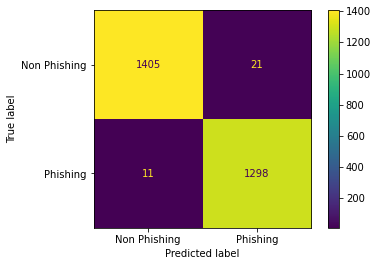

In [39]:
cm = confusion_matrix(y_test, pred)
plot = ConfusionMatrixDisplay(cm, ['Non Phishing', 'Phishing'])
plot.plot()

## Text processing for SVM and Naive Bayes

In [40]:
df['Text'] = df['Text'].apply(lambda x: word_tokenize(x))

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in df['Text'].iteritems():
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'text_final'] = str(Final_words)

In [41]:
df['text_final']=df['text_final'].astype(str)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9116 entries, 0 to 11928
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         9116 non-null   object
 1   Class        9116 non-null   int64 
 2   Has_Email    9116 non-null   int64 
 3   Has_URL      9116 non-null   int64 
 4   Text_Length  9116 non-null   int64 
 5   text_final   9116 non-null   object
dtypes: int64(4), object(2)
memory usage: 756.6+ KB


#### Split into train and test data

In [43]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text_final'], df['Class'],test_size=0.3)

In [44]:
df['text_final'].describe()

count     9116
unique    8775
top         []
freq       130
Name: text_final, dtype: object

####  Extracting text features from the data using TFID to fit and transform the data

In [45]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

#### Build piplelines to manage the workflow

In [46]:
pipe_svm = Pipeline([('clf', SVC(random_state=42))])

pipe_nb = Pipeline([('clf', naive_bayes.MultinomialNB())])

pipe_lr = Pipeline([('clf', LogisticRegression())])

In [52]:

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'],
                    'clf__C': list(range(1, 11, 2))}]

grid_params_nb = [{'clf__alpha': [0,1.0]}]

grid_params_lr = [{"clf__C":np.logspace(-3,3,7),
                   "clf__penalty":["none","l1","l2"]}]

In [53]:
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [54]:
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=inner_cv)

gs_nb = GridSearchCV(estimator=pipe_nb,
			param_grid=grid_params_nb,
			scoring='accuracy',
			cv=inner_cv)


gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=inner_cv,
			n_jobs=jobs)

grids = [gs_svm, gs_nb, gs_lr]

grid_dict = {0: 'SVM',
             1: 'Naive Bayes',
             2: 'Logistic Regression'}

In [55]:
# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
clf_dict, cv_results = dict(), dict()
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(Train_X_Tfidf, Train_Y)
    clf_dict[idx] = gs
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Outer cross validation loop
    cv_scores = cross_val_score(gs, Train_X_Tfidf, Train_Y, cv=outer_cv)
    cv_results[grid_dict[idx]] = cv_scores
    # Predict on test data with best params
    y_pred = gs.predict(Test_X_Tfidf)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % metrics.accuracy_score(Test_Y, y_pred))
    # Track best (highest test accuracy) model
    if metrics.accuracy_score(Test_Y, y_pred) > best_acc:
        best_acc = metrics.accuracy_score(Test_Y, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
# plot model performance for comparison
plt.boxplot(list(cv_results.values()), labels=list(cv_results.keys()), showmeans=True)
plt.xticks(rotation = 90)
plt.title('Model cross validation performance')
plt.show()

Performing model optimizations...

Estimator: SVM
Best params: {'clf__C': 3, 'clf__kernel': 'rbf'}
Best training accuracy: 0.985
Test set accuracy score for best params: 0.987 

Estimator: Logistic Regression
Best params: {'clf__alpha': 1.0}
Best training accuracy: 0.974
Test set accuracy score for best params: 0.974 


C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\jayan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


KeyError: 2

In [ ]:
naive_bayes.MultinomialNB().get_params().keys()

In [ ]:

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(Test_Y, predictions_NB)*100)

In [ ]:
Train_X_Tfidf


In [ ]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'eval_metric': 'Accuracy',
    'task_type': 'GPU',
    'early_stopping_rounds': 2000,
    'use_best_model': True,
    'verbose': 500
}
class_weight = [5,4]
model = CatBoostClassifier(**catboost_params,class_weights=class_weight)
model.fit(train_pool, eval_set=valid_pool)

In [ ]:
pred = model.predict(X_test)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))